In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
# import signal_generation as sg
# import channel_model as ch
import hpcom
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
# from sklearn.externals import joblib
from datetime import datetime
from importlib import reload
reload(hpcom)

from composer import *
from estimator import *


In [228]:
# path_to_data = 'C:/Users/190243539/PycharmProjects/nn_essential/error_statistics/data/data_collected_3.pkl'
# path_to_data = 'C:/Users/190243539/PycharmProjects/nn_essential/benchmark/data/data_collected_extended_wo_noise_1.pkl'
# path_to_data_w_noise = 'C:/Users/190243539/PycharmProjects/nn_essential/benchmark/data/data_collected_extended_w_noise_1.pkl'
path_to_data = '/users/1/190243539/files/data_collected_extended_wo_noise_2.pkl'
path_to_data_w_noise = '/users/1/190243539/files/data_collected_extended_w_noise_2.pkl'

df = pd.read_pickle(path_to_data)
df_noise = pd.read_pickle(path_to_data_w_noise)


n_neighbours = 5
n_gauss = 0
train_runs = [k for k in range(18)]

# train_runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# train_runs = [0, 1, 2, 3, 4, 5, 6]
# train_runs = [0, 1, 2]

test_runs = [k for k in range(18, 20)]
# test_runs = [0, 1]
# test_runs = [8, 9]

p_ave_dbm = 6
z_km = 80 * 20
n_channels = 1
sigma = 1.5

print(df.size, df_noise.size)
df = pd.concat([df, df_noise], ignore_index=True, sort=False)
print(df.size)
df_tree = get_data_with_m_neighbor(df, z_km, p_ave_dbm, n_channels, train_runs, n_neighbours, r=0.1, n_gauss=n_gauss)
# df_tree = get_data_with_m_neighbor(df_noise, z_km, p_ave_dbm, n_channels, train_runs, n_neighbours, 
#                                    r=0.1, n_gauss=n_gauss, scale_type='constellation')
df_tree_for_test = get_data_with_m_neighbor(df_noise, z_km, p_ave_dbm, n_channels, test_runs, n_neighbours, 
                                            r=0.1, n_gauss=n_gauss, scale_type='constellation')

# df_tree = get_data_gauss_parallel(df, z_km, p_ave_dbm, n_channels, train_runs, n_neighbours, r=0.1, n_gauss=n_gauss, sigma=sigma)
# df_tree_for_test = get_data_gauss_parallel(df, z_km, p_ave_dbm, n_channels, test_runs, n_neighbours, r=0.1, n_gauss=1, sigma=sigma)

print(df_tree.head())
df = pd.DataFrame([])
df_noise = pd.DataFrame([])
del df, df_noise

6720 6720
13440
Scale data to correspond to initial constellation
['point_orig_abs', 'point_orig_angle', 'point_orig_real', 'point_orig_imag', 'point_label', 'diff_real', 'diff_imag', 'diff_sq_real', 'diff_sq_imag', 'diff_circle_real', 'diff_circle_imag', 'diff_p3_real', 'diff_p3_imag', 'minus_m_5_x_abs', 'minus_m_4_x_abs', 'minus_m_3_x_abs', 'minus_m_2_x_abs', 'minus_m_1_x_abs', 'point_x_abs', 'plus_m_1_x_abs', 'plus_m_2_x_abs', 'plus_m_3_x_abs', 'plus_m_4_x_abs', 'plus_m_5_x_abs', 'minus_m_5_x_angle', 'minus_m_4_x_angle', 'minus_m_3_x_angle', 'minus_m_2_x_angle', 'minus_m_1_x_angle', 'point_x_angle', 'plus_m_1_x_angle', 'plus_m_2_x_angle', 'plus_m_3_x_angle', 'plus_m_4_x_angle', 'plus_m_5_x_angle', 'minus_m_5_x_real', 'minus_m_4_x_real', 'minus_m_3_x_real', 'minus_m_2_x_real', 'minus_m_1_x_real', 'point_x_real', 'plus_m_1_x_real', 'plus_m_2_x_real', 'plus_m_3_x_real', 'plus_m_4_x_real', 'plus_m_5_x_real', 'minus_m_5_x_imag', 'minus_m_4_x_imag', 'minus_m_3_x_imag', 'minus_m_2_x_imag',

In [229]:
print("P_ave [dBm] = ", p_ave_dbm)
p_ave = (10 ** (p_ave_dbm / 10)) / 1000
mod_type = hpcom.modulation.get_modulation_type_from_order(16)
scale_constellation = hpcom.modulation.get_scale_coef_constellation(mod_type) / np.sqrt(p_ave / 2)
constellation = hpcom.modulation.get_constellation('16qam')

P_ave [dBm] =  6


In [230]:
labels_to_drop = ['point_orig_abs', 'point_orig_angle',
                  'point_orig_real', 'point_orig_imag',
                  'point_label',
                  'diff_real', 'diff_imag',
                  'diff_sq_real', 'diff_sq_imag',
                  'diff_circle_real', 'diff_circle_imag',
                  'diff_p3_real', 'diff_p3_imag']

# for get_data_with_m_neighbor
labels_to_drop = labels_to_drop + [f'diff_gauss_{m}_real' for m in range(n_gauss)] + [f'diff_gauss_{m}_imag' for m in range(n_gauss)]

# for get_data_gauss_parallel
# labels_to_drop = labels_to_drop + [f'diff_gauss_real'] + [f'diff_gauss_imag']

# chose what to predict
# label_predict = ['diff_circle_real', 'diff_circle_imag']
label_predict = ['diff_real', 'diff_imag']
m = 5
# label_predict = [f'diff_gauss_{m}_real', f'diff_gauss_{m}_imag']
# label_predict = [f'diff_gauss_real', f'diff_gauss_imag']
# label_predict = ['diff_p3_real', 'diff_p3_imag']
# label_predict = ['point_label']

In [231]:
X_for_test = df_tree_for_test.drop(labels=labels_to_drop, axis=1)
points_init_for_test = df_tree_for_test['point_orig_abs'].values * np.exp(1.0j * df_tree_for_test['point_orig_angle'])
labels_for_test = df_tree_for_test['point_label']

In [232]:
y = df_tree[[label_predict[0], label_predict[1]]].values
X = df_tree.drop(labels=labels_to_drop, axis=1)

In [233]:
split_ratio = 0.01
random_state = 42

# X_train, X_test, y_real_train, y_real_test = train_test_split(X, y_real, test_size=split_ratio, random_state=random_state)
# _, _, y_imag_train, y_imag_test = train_test_split(X, y_imag, test_size=split_ratio, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio, random_state=random_state)
po_abs_train, po_abs_test, po_angle_train, po_angle_test = train_test_split(df_tree['point_orig_abs'].values, df_tree['point_orig_angle'].values, test_size=split_ratio, random_state=random_state)

## Random Forest

In [87]:
n_estimators = 100
n_jobs = 60  # number of cores to use
random_state_for_tree = 73
start_time = datetime.now()
# model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state_for_tree, n_jobs=n_jobs, verbose=1)
model.warm_start = True  # start from previous state of the forest (add new trees)
model.n_estimators += n_estimators
model.fit(X_train, y_train)

calculation_time = (datetime.now() - start_time).total_seconds()
print("model took: \n", 
      calculation_time * 1000, "ms \n",
      calculation_time, "s \n",
      calculation_time / 60., "min \n")

[Parallel(n_jobs=60)]: Using backend ThreadingBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done  82 out of 100 | elapsed:  7.1min remaining:  1.6min


model took: 
 468985.67100000003 ms 
 468.985671 s 
 7.81642785 min 



[Parallel(n_jobs=60)]: Done 100 out of 100 | elapsed:  7.8min finished


In [88]:
points_orig_for_test, points_predict_for_test = predict_and_eval((model, ), 
                                                                 X_for_test, 
                                                                 points_init_for_test, 
                                                                 p_ave_dbm, 
                                                                 scale_type='constellation',
                                                                 name='RF new data test')

_ = predict_and_eval((model, ), X_test, po_abs_test * np.exp(1.0j * po_angle_test), 
                     p_ave_dbm, 
                     scale_type='constellation',
                     name='RF same data test')

points_orig_train, points_predict_train = predict_and_eval((model, ), X_train, po_abs_train * np.exp(1.0j * po_angle_train), 
                                                           p_ave_dbm, 
                                                           scale_type='constellation',
                                                           name='RF same data train')

[Parallel(n_jobs=60)]: Using backend ThreadingBackend with 60 concurrent workers.


P_ave [dBm] =  4
Scale data to correspond to initial constellation


[Parallel(n_jobs=60)]: Done  80 tasks      | elapsed:    0.7s
[Parallel(n_jobs=60)]: Done 200 out of 200 | elapsed:    1.8s finished


-----RF new data test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.011508941650390625, 6034) / (0.010768890380859375, 5646) / 0.00074005126953125)
ber from EVM_rms (orig / pred / delta) (0.010381668571007883 / 4.306274639952746e-05 / 0.010338605824608356)
q-factor [dB] (orig / pred / delta) (7.1325148884243905 / 7.228595519598011 / 0.09608063117362065)
EVM [%] (orig / pred / delta) (20.31192640559659 / 11.595155828831368 / 8.716770576765223
P_ave [dBm] =  4
Scale data to correspond to initial constellation
-----RF same data test-----
Number of points (11797,)
ber (orig / pred / delta) ((0.010807832499788082, 510) / (0.010489955073323726, 495) / 0.0003178774264643563)
ber from EVM_rms (orig / pred / delta) (0.009698859509102539 / 2.9161958366520238e-05 / 0.009669697550736019)
q-factor [dB] (orig / pred / delta) (7.223425717450912 / 7.2660174265693565 / 0.042591709118444676)
EVM [%] (orig / pred / delta) (20.070141296562408 / 11.318468012349813 / 8.751673284212595


[Parallel(n_jobs=60)]: Using backend ThreadingBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done  80 tasks      | elapsed:    0.1s
[Parallel(n_jobs=60)]: Done 200 out of 200 | elapsed:    0.1s finished


P_ave [dBm] =  4
Scale data to correspond to initial constellation


[Parallel(n_jobs=60)]: Using backend ThreadingBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done  80 tasks      | elapsed:    4.4s
[Parallel(n_jobs=60)]: Done 200 out of 200 | elapsed:    8.9s finished


-----RF same data train-----
Number of points (1167851,)
ber (orig / pred / delta) ((0.011244157002905337, 52526) / (8.562736170967016e-07, 4) / 0.01124330072928824)
ber from EVM_rms (orig / pred / delta) (0.010146538091955827 / 4.85542307706776e-26 / 0.010146538091955827)
q-factor [dB] (orig / pred / delta) (7.166378965097606 / 13.597069099638322 / 6.430690134540716)
EVM [%] (orig / pred / delta) (20.229609569546618 / 4.274759991984622 / 15.954849577561994


Scale data to correspond to initial constellation


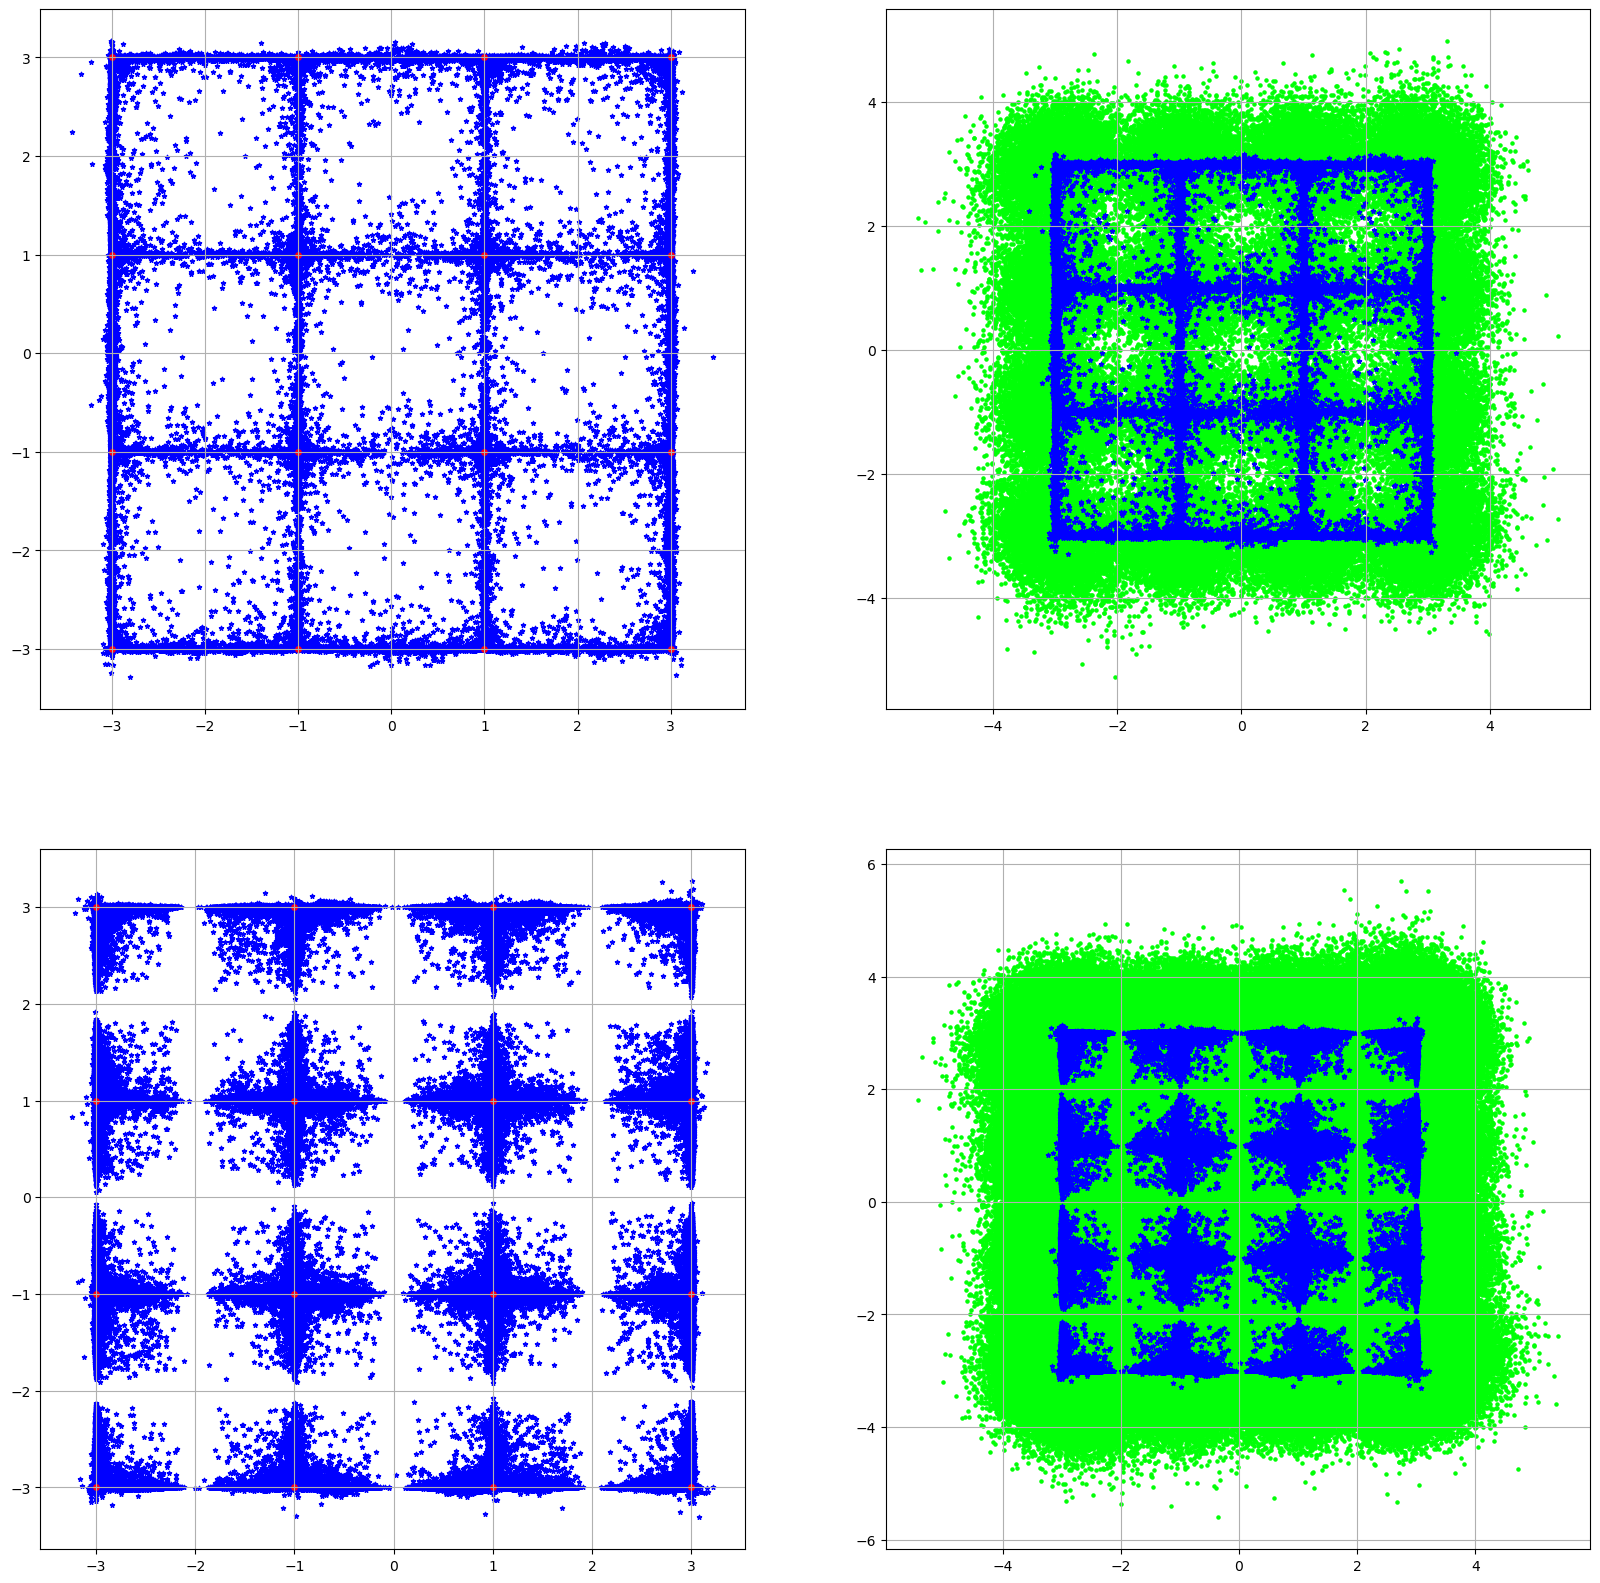

In [89]:
plot_result(p_ave_dbm, 
            points_predict_for_test, points_orig_for_test, 
            points_predict_train, points_orig_train)

#### Test with other p_ave

In [23]:
def get_data_for_test(path_to_data, p_ave_dbm, z_km,
                      test_runs,
                      n_channels=1,
                      n_neighbours=4,
                      n_gauss=0):
    
    df = pd.read_pickle(path_to_data)

    sigma = 1.5


    df_tree_for_test = get_data_with_m_neighbor(df, z_km, p_ave_dbm, n_channels, test_runs, n_neighbours, 
                                                r=0.1, n_gauss=n_gauss, scale_type='constellation')
    # df_tree_for_test = get_data_gauss_parallel(df, z_km, p_ave_dbm, n_channels, test_runs, n_neighbours, r=0.1, n_gauss=1, sigma=sigma)

    df = pd.DataFrame([])
    del df
    
    labels_to_drop = ['point_orig_abs', 'point_orig_angle',
                  'point_orig_real', 'point_orig_imag',
                  'point_label',
                  'diff_real', 'diff_imag',
                  'diff_sq_real', 'diff_sq_imag',
                  'diff_circle_real', 'diff_circle_imag',
                  'diff_p3_real', 'diff_p3_imag']

    # for get_data_with_m_neighbor
    labels_to_drop = labels_to_drop + [f'diff_gauss_{m}_real' for m in range(n_gauss)] + [f'diff_gauss_{m}_imag' for m in range(n_gauss)]

    # for get_data_gauss_parallel
    # labels_to_drop = labels_to_drop + [f'diff_gauss_real'] + [f'diff_gauss_imag']

    
    X_for_test = df_tree_for_test.drop(labels=labels_to_drop, axis=1)
    points_init_for_test = df_tree_for_test['point_orig_abs'].values * np.exp(1.0j * df_tree_for_test['point_orig_angle'])
    labels_for_test = df_tree_for_test['point_label']
    
    return X_for_test, points_init_for_test



In [244]:
X_test_2dbm, points_init_test_2dbm = get_data_for_test(path_to_data_w_noise, 
                                                       p_ave_dbm=2,
                                                       z_km = z_km,
                                                       test_runs = test_runs,
                                                       n_channels=1,
                                                       n_neighbours=n_neighbours,
                                                       n_gauss=0)

X_test_3dbm, points_init_test_3dbm = get_data_for_test(path_to_data_w_noise, 
                                                       p_ave_dbm=3,
                                                       z_km = z_km,
                                                       test_runs = test_runs,
                                                       n_channels=1,
                                                       n_neighbours=n_neighbours,
                                                       n_gauss=0)

X_test_4dbm, points_init_test_4dbm = get_data_for_test(path_to_data_w_noise, 
                                                       p_ave_dbm=4,
                                                       z_km = z_km,
                                                       test_runs = test_runs,
                                                       n_channels=1,
                                                       n_neighbours=n_neighbours,
                                                       n_gauss=0)

X_test_5dbm, points_init_test_5dbm = get_data_for_test(path_to_data_w_noise, 
                                                       p_ave_dbm=5,
                                                       z_km = z_km,
                                                       test_runs = test_runs,
                                                       n_channels=1,
                                                       n_neighbours=n_neighbours,
                                                       n_gauss=0)


X_test_6dbm, points_init_test_6dbm = get_data_for_test(path_to_data_w_noise, 
                                                       p_ave_dbm=6,
                                                       z_km = z_km,
                                                       test_runs = test_runs,
                                                       n_channels=1,
                                                       n_neighbours=n_neighbours,
                                                       n_gauss=0)

X_test_7dbm, points_init_test_7dbm = get_data_for_test(path_to_data_w_noise, 
                                                       p_ave_dbm=7,
                                                       z_km = z_km,
                                                       test_runs = test_runs,
                                                       n_channels=1,
                                                       n_neighbours=n_neighbours,
                                                       n_gauss=0)

X_test_8dbm, points_init_test_8dbm = get_data_for_test(path_to_data_w_noise, 
                                                       p_ave_dbm=8,
                                                       z_km = z_km,
                                                       test_runs = test_runs,
                                                       n_channels=1,
                                                       n_neighbours=n_neighbours,
                                                       n_gauss=0)

Scale data to correspond to initial constellation
['point_orig_abs', 'point_orig_angle', 'point_orig_real', 'point_orig_imag', 'point_label', 'diff_real', 'diff_imag', 'diff_sq_real', 'diff_sq_imag', 'diff_circle_real', 'diff_circle_imag', 'diff_p3_real', 'diff_p3_imag', 'minus_m_5_x_abs', 'minus_m_4_x_abs', 'minus_m_3_x_abs', 'minus_m_2_x_abs', 'minus_m_1_x_abs', 'point_x_abs', 'plus_m_1_x_abs', 'plus_m_2_x_abs', 'plus_m_3_x_abs', 'plus_m_4_x_abs', 'plus_m_5_x_abs', 'minus_m_5_x_angle', 'minus_m_4_x_angle', 'minus_m_3_x_angle', 'minus_m_2_x_angle', 'minus_m_1_x_angle', 'point_x_angle', 'plus_m_1_x_angle', 'plus_m_2_x_angle', 'plus_m_3_x_angle', 'plus_m_4_x_angle', 'plus_m_5_x_angle', 'minus_m_5_x_real', 'minus_m_4_x_real', 'minus_m_3_x_real', 'minus_m_2_x_real', 'minus_m_1_x_real', 'point_x_real', 'plus_m_1_x_real', 'plus_m_2_x_real', 'plus_m_3_x_real', 'plus_m_4_x_real', 'plus_m_5_x_real', 'minus_m_5_x_imag', 'minus_m_4_x_imag', 'minus_m_3_x_imag', 'minus_m_2_x_imag', 'minus_m_1_x_im

run number 19
(65536, 11)
Scale data to correspond to initial constellation
['point_orig_abs', 'point_orig_angle', 'point_orig_real', 'point_orig_imag', 'point_label', 'diff_real', 'diff_imag', 'diff_sq_real', 'diff_sq_imag', 'diff_circle_real', 'diff_circle_imag', 'diff_p3_real', 'diff_p3_imag', 'minus_m_5_x_abs', 'minus_m_4_x_abs', 'minus_m_3_x_abs', 'minus_m_2_x_abs', 'minus_m_1_x_abs', 'point_x_abs', 'plus_m_1_x_abs', 'plus_m_2_x_abs', 'plus_m_3_x_abs', 'plus_m_4_x_abs', 'plus_m_5_x_abs', 'minus_m_5_x_angle', 'minus_m_4_x_angle', 'minus_m_3_x_angle', 'minus_m_2_x_angle', 'minus_m_1_x_angle', 'point_x_angle', 'plus_m_1_x_angle', 'plus_m_2_x_angle', 'plus_m_3_x_angle', 'plus_m_4_x_angle', 'plus_m_5_x_angle', 'minus_m_5_x_real', 'minus_m_4_x_real', 'minus_m_3_x_real', 'minus_m_2_x_real', 'minus_m_1_x_real', 'point_x_real', 'plus_m_1_x_real', 'plus_m_2_x_real', 'plus_m_3_x_real', 'plus_m_4_x_real', 'plus_m_5_x_real', 'minus_m_5_x_imag', 'minus_m_4_x_imag', 'minus_m_3_x_imag', 'minus_m_

In [90]:
_ = predict_and_eval((model, ), 
                     X_test_5dbm, points_init_test_5dbm, 
                     p_ave_dbm=5, scale_type='constellation', name='RF 5 dbm test')

_ = predict_and_eval((model, ), 
                     X_test_4dbm, points_init_test_4dbm, 
                     p_ave_dbm=4, scale_type='constellation', name='RF 4 dbm test')

_ = predict_and_eval((model, ), 
                     X_test_6dbm, points_init_test_6dbm, 
                     p_ave_dbm=6, scale_type='constellation', name='RF 6 dbm test')

_ = predict_and_eval((model, ), 
                     X_test_7dbm, points_init_test_7dbm, 
                     p_ave_dbm=7, scale_type='constellation', name='RF 7 dbm test')

P_ave [dBm] =  5
Scale data to correspond to initial constellation


[Parallel(n_jobs=60)]: Using backend ThreadingBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done  80 tasks      | elapsed:    0.7s
[Parallel(n_jobs=60)]: Done 200 out of 200 | elapsed:    1.2s finished


-----RF 5 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.026178359985351562, 13725) / (0.025068283081054688, 13143) / 0.001110076904296875)
ber from EVM_rms (orig / pred / delta) (0.026236106958939243 / 0.004353198025032555 / 0.021882908933906688)
q-factor [dB] (orig / pred / delta) (5.756880940123481 / 5.839788562869883 / 0.08290762274640162)
EVM [%] (orig / pred / delta) (24.678612856337605 / 17.719666374549952 / 6.958946481787653
P_ave [dBm] =  4
Scale data to correspond to initial constellation


[Parallel(n_jobs=60)]: Using backend ThreadingBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=60)]: Done 200 out of 200 | elapsed:    1.0s finished


-----RF 4 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.011217117309570312, 5881) / (0.0001010894775390625, 53) / 0.01111602783203125)
ber from EVM_rms (orig / pred / delta) (0.010278922950172133 / 1.9807122623010305e-24 / 0.010278922950172133)
q-factor [dB] (orig / pred / delta) (7.169868526851037 / 11.402164377946447 / 4.23229585109541)
EVM [%] (orig / pred / delta) (20.276073991253067 / 4.425930154201199 / 15.850143837051869
P_ave [dBm] =  6
Scale data to correspond to initial constellation


[Parallel(n_jobs=60)]: Using backend ThreadingBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=60)]: Done 200 out of 200 | elapsed:    1.0s finished


-----RF 6 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.050571441650390625, 26514) / (0.04932403564453125, 25860) / 0.001247406005859375)
ber from EVM_rms (orig / pred / delta) (0.05200937059976101 / 0.027023960428913398 / 0.024985410170847613)
q-factor [dB] (orig / pred / delta) (4.2933701927694745 / 4.357273816119125 / 0.06390362334965083)
EVM [%] (orig / pred / delta) (30.203241513047274 / 24.862959575540387 / 5.340281937506888
P_ave [dBm] =  7
Scale data to correspond to initial constellation


[Parallel(n_jobs=60)]: Using backend ThreadingBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done  80 tasks      | elapsed:    0.4s
[Parallel(n_jobs=60)]: Done 200 out of 200 | elapsed:    0.9s finished


-----RF 7 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.09035682678222656, 47373) / (0.09062767028808594, 47515) / -0.000270843505859375)
ber from EVM_rms (orig / pred / delta) (0.09368914562674342 / 0.07127435339554387 / 0.02241479223119955)
q-factor [dB] (orig / pred / delta) (2.5327628687682506 / 2.521977276941136 / -0.010785591827114693)
EVM [%] (orig / pred / delta) (38.86300858403585 / 34.12835968635245 / 4.734648897683408


### Thin out the forest

In [ ]:
# model has N trees

evm_for_each_tree = []
k_stop = 10  # I like that it sounds like k-pop
k = 0
for tree in model:
    ber, evm = predict_and_eval_short((tree, ), X_for_test, points_init_for_test, p_ave_dbm, name='new data test')
    evm_for_each_tree.append(evm)
    if k == k_stop:
        break
    
evm_for_each_tree = np.array(evm_for_each_tree)


In [ ]:
pos_min = np.argmax(evm_for_each_tree)
print(pos_min, evm_for_each_tree[pos_min])

In [ ]:
y_pred = model[pos_min].predict(X_for_test.values)
print(y_pred, np.shape(y_pred))

In [ ]:
y_pred = np.zeros((131072, 2))
for tree in model:
    y_pred = y_pred + tree.predict(X_for_test.values)

In [ ]:
points_orig = X_for_test['point_x_abs'].values * np.exp(1.0j * X_for_test['point_x_angle'].values)
points_predict = np.real(points_orig) + y_pred[:,0] + 1.0j * (np.imag(points_orig) + y_pred[:,1])

In [ ]:
p_found_orig_for_test = hpcom.modulation.get_nearest_constellation_points_new(points_orig * scale_constellation, constellation)
p_found_pred_for_test = hpcom.modulation.get_nearest_constellation_points_new(points_predict * scale_constellation, constellation)

ber_orig = hpcom.metrics.get_ber_by_points(points_init_for_test * scale_constellation, p_found_orig_for_test, '16qam')
ber_predict = hpcom.metrics.get_ber_by_points(points_init_for_test * scale_constellation, p_found_pred_for_test, '16qam')

q_orig = np.sqrt(2) * sp.special.erfcinv(2 * ber_orig[0])
q_pred = np.sqrt(2) * sp.special.erfcinv(2 * ber_predict[0])
q_orig_db = 20 * np.log10(q_orig)
q_pred_db = 20 * np.log10(q_pred)
evm_orig = hpcom.metrics.get_evm_rms_new(points_init_for_test, points_orig)
evm_pred = hpcom.metrics.get_evm_rms_new(points_init_for_test, points_predict)
ber_evm_orig = hpcom.metrics.get_ber_from_evm(points_init_for_test, points_orig, 16)
ber_evm_pred = hpcom.metrics.get_ber_from_evm(points_init_for_test, points_predict, 16)

name = 'test'
name = name.center(len(name) + 10, '-')
print_out = [name, f'Number of points {np.shape(points_init_for_test)}',
             f'ber (orig / pred / delta) ({ber_orig} / {ber_predict} / {ber_orig[0] - ber_predict[0]})',
             f'ber from EVM_rms (orig / pred / delta) ({ber_evm_orig} / {ber_evm_pred} / {ber_evm_orig - ber_evm_pred})',
             f'q-factor [dB] (orig / pred / delta) ({q_orig_db} / {q_pred_db} / {q_pred_db - q_orig_db})',
             f'EVM [%] (orig / pred / delta) ({evm_orig * 100.} / {evm_pred * 100.} / {(evm_orig - evm_pred) * 100}']

for line in print_out:
    print(line)

## Tree  

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
random_state_for_tree = 73
max_depth = 5

start_time = datetime.now()

regression_tree = DecisionTreeRegressor(random_state=random_state_for_tree, 
                                         max_depth=max_depth)
regression_tree.fit(X_train, y_train)

calculation_time = (datetime.now() - start_time).total_seconds()
print("model took: \n", 
      calculation_time * 1000, "ms \n",
      calculation_time, "s \n",
      calculation_time / 60., "min \n")

In [ ]:
points_orig_for_test, points_predict_for_test = predict_and_eval((regression_tree, ), X_for_test, points_init_for_test, p_ave_dbm, name='new data test')
_ = predict_and_eval((regression_tree, ), X_test, po_abs_test * np.exp(1.0j * po_angle_test), p_ave_dbm, name='same data test')
points_orig_train, points_predict_train = predict_and_eval((regression_tree, ), X_train, po_abs_train * np.exp(1.0j * po_angle_train), p_ave_dbm, name='same data train')

In [ ]:
plot_result(p_ave_dbm, points_predict_for_test, points_orig_for_test, points_predict_train, points_orig_train)

In [ ]:
def predict_and_eval_short(model, X_test, points_init, p_ave_dbm, name='test'):

    # p_ave_dbm_expl = 6
    p_ave_dbm_expl = p_ave_dbm
    print("P_ave [dBm] = ", p_ave_dbm_expl)
    p_ave_expl = (10 ** (p_ave_dbm_expl / 10)) / 1000
    mod_type = hpcom.modulation.get_modulation_type_from_order(16)
    scale_constellation = hpcom.modulation.get_scale_coef_constellation(mod_type) / np.sqrt(p_ave_expl / 2)
    constellation = hpcom.modulation.get_constellation('16qam')

    points_orig = X_test['point_x_abs'].values * np.exp(1.0j * X_test['point_x_angle'].values)
    # points_predict = predict(model_real, model_imag, X_test, inverse_function=inverse_p3, parameters=[scale_constellation])
    if len(model) == 2:
        points_predict = predict(model[0], model[1], X_test, inverse_function=None, parameters=None)
    else:
        points_predict = predict_single(model[0], X_test, inverse_function=None, parameters=None)



    p_found_orig_for_test = hpcom.modulation.get_nearest_constellation_points_new(points_orig * scale_constellation, constellation)
    p_found_pred_for_test = hpcom.modulation.get_nearest_constellation_points_new(points_predict * scale_constellation, constellation)

    ber_orig = hpcom.metrics.get_ber_by_points(points_init * scale_constellation, p_found_orig_for_test, '16qam')
    ber_predict = hpcom.metrics.get_ber_by_points(points_init * scale_constellation, p_found_pred_for_test, '16qam')

    q_orig = np.sqrt(2) * sp.special.erfcinv(2 * ber_orig[0])
    q_pred = np.sqrt(2) * sp.special.erfcinv(2 * ber_predict[0])
    q_orig_db = 20 * np.log10(q_orig)
    q_pred_db = 20 * np.log10(q_pred)
    evm_orig = hpcom.metrics.get_evm_rms_new(points_init, points_orig)
    evm_pred = hpcom.metrics.get_evm_rms_new(points_init, points_predict)
    ber_evm_orig = hpcom.metrics.get_ber_from_evm(points_init, points_orig, 16)
    ber_evm_pred = hpcom.metrics.get_ber_from_evm(points_init, points_predict, 16)
    
    name = name.center(len(name) + 10, '-')
    print_out = [name, f'Number of points {np.shape(points_init)}',
                 f'ber (orig / pred / delta) ({ber_orig} / {ber_predict} / {ber_orig[0] - ber_predict[0]})',
                 f'ber from EVM_rms (orig / pred / delta) ({ber_evm_orig} / {ber_evm_pred} / {ber_evm_orig - ber_evm_pred})',
                 f'q-factor [dB] (orig / pred / delta) ({q_orig_db} / {q_pred_db} / {q_pred_db - q_orig_db})',
                 f'EVM [%] (orig / pred / delta) ({evm_orig * 100.} / {evm_pred * 100.} / {(evm_orig - evm_pred) * 100}']
    
#     print(print_out[2])
#     print(print_out[4])
#     print(print_out[5])

    return ber_orig[0] - ber_predict[0], evm_orig - evm_pred

In [ ]:
np.random.randint(1, 1000)

In [ ]:
## We want to select that trees which gives us the best results

n_trees_total = 10
forest = []
n_trees_selected = 0

limit_max_depth = 1000

verbose = 1

start_time = datetime.now()
while n_trees_selected < n_trees_total:
    # here we train each tree and than select if it is alright for us or not
    
    max_depth = np.random.randint(1, limit_max_depth)
#     random_state_for_tree = np.random.randint(1, 10000)
    
    start_time = datetime.now()
    
#     regression_tree = DecisionTreeRegressor(random_state=random_state_for_tree, 
#                                             max_depth=max_depth)
    regression_tree = DecisionTreeRegressor(max_depth=max_depth)
    regression_tree = regression_tree.fit(X_train, y_train)
    
    if verbose >= 1:
        calculation_time = (datetime.now() - start_time).total_seconds()
        print("\n tree took: ", calculation_time * 1000, "ms \n")
        
    
    
    ber_delta = predict_and_eval_short((regression_tree, ), X_for_test, points_init_for_test, p_ave_dbm, name='new data test')
    print(ber_delta)
    
    if ber_delta > 0:
#         print(ber_delta)
        forest.append([regression_tree, ber_delta])
        n_trees_selected = n_trees_selected + 1
        
    if n_trees_selected % 1 == 0:
        print(n_trees_selected, '/', n_trees_total)

calculation_time = (datetime.now() - start_time).total_seconds()
print("model took: \n", 
      calculation_time * 1000, "ms \n",
      calculation_time, "s \n",
      calculation_time / 60., "min \n")
    

## Gradient Boosting

### SKLearn

In [ ]:
y_train

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
random_state_for_tree = 73

n_estimators = 100
learning_rate = 0.1

start_time = datetime.now()

# gb_tree_real = GradientBoostingRegressor(random_state=random_state_for_tree,
#                                          n_estimators=n_estimators,
#                                          learning_rate=learning_rate,
#                                          verbose=1)
gb_tree_real.warm_start = True
gb_tree_real.n_estimators += n_estimators
gb_tree_real.fit(X_train, y_train[:, 0])  # y_train[:, 0] correesponds to real part

calculation_time = (datetime.now() - start_time).total_seconds()
print("model took: \n", 
      calculation_time * 1000, "ms \n",
      calculation_time, "s \n",
      calculation_time / 60., "min \n")

In [ ]:
start_time = datetime.now()

# gb_tree_imag = GradientBoostingRegressor(random_state=random_state_for_tree,
#                                          n_estimators=n_estimators,
#                                          learning_rate=learning_rate,
#                                          verbose=1)
gb_tree_imag.warm_start = True
gb_tree_imag.n_estimators += n_estimators
gb_tree_imag.fit(X_train, y_train[:, 1])  # y_train[:, 0] correesponds to real part

calculation_time = (datetime.now() - start_time).total_seconds()
print("model took: \n", 
      calculation_time * 1000, "ms \n",
      calculation_time, "s \n",
      calculation_time / 60., "min \n")

In [ ]:
points_orig_for_test, points_predict_for_test = predict_and_eval((gb_tree_real, gb_tree_imag), X_for_test, points_init_for_test, p_ave_dbm, name='GBR new data test')
_ = predict_and_eval((gb_tree_real, gb_tree_imag), X_test, po_abs_test * np.exp(1.0j * po_angle_test), p_ave_dbm, name='GBR same data test')
points_orig_train, points_predict_train = predict_and_eval((gb_tree_real, gb_tree_imag), X_train, po_abs_train * np.exp(1.0j * po_angle_train), p_ave_dbm, name='GBR same data train')

In [ ]:
plot_result(p_ave_dbm, points_predict_for_test, points_orig_for_test, points_predict_train, points_orig_train)

### XGBoost

#### Scikit-learn interface

In [91]:
import xgboost as xgb

In [249]:
# Scikit-Learn interface

random_state_for_tree = 0
learning_rate = 0.4
reg_lambda = 0.0  # 1.0 - L2 regularization term on weights. Increasing this value will make model more conservative.
reg_alpha = 0.9  # 0.0 - L1 regularization term on weights. Increasing this value will make model more conservative.
n_estimators = 20000
max_depth = 200

start_time = datetime.now()
# Use "gpu_hist" for training the model.
xgb_reg = xgb.XGBRegressor(tree_method="gpu_hist",
                           n_estimators=n_estimators,
                           learning_rate=learning_rate,
                           reg_lambda=reg_lambda,
                           reg_alpha=reg_alpha,
                           seed=random_state_for_tree)
# Fit the model using predictor X and response y.
xgb_reg.fit(X_train, y_train)

calculation_time = (datetime.now() - start_time).total_seconds()
print("model took: \n", 
      calculation_time * 1000, "ms \n",
      calculation_time, "s \n",
      calculation_time / 60., "min \n")

# Save model into JSON format.
# reg.save_model("regressor.json")

model took: 
 335857.33800000005 ms 
 335.857338 s 
 5.5976223 min 



In [247]:
points_orig_for_test, points_predict_for_test = predict_and_eval((xgb_reg,), X_for_test, points_init_for_test, p_ave_dbm, name='XGBR new data test')
_ = predict_and_eval((xgb_reg,), X_test, po_abs_test * np.exp(1.0j * po_angle_test), p_ave_dbm, name='XGBR same data test')
points_orig_train, points_predict_train = predict_and_eval((xgb_reg,), X_train, po_abs_train * np.exp(1.0j * po_angle_train), p_ave_dbm, name='XGBR same data train')

P_ave [dBm] =  6
Scale data to correspond to initial constellation
-----XGBR new data test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.05119895935058594, 26843) / (0.040676116943359375, 21326) / 0.010522842407226562)
ber from EVM_rms (orig / pred / delta) (0.05273226557700926 / 0.02191034829214531 / 0.03082191728486395)
q-factor [dB] (orig / pred / delta) (4.261521580718789 / 4.825416598905163 / 0.5638950181863747)
EVM [%] (orig / pred / delta) (30.350668461576035 / 23.631137622002303 / 6.719530839573731
P_ave [dBm] =  6
Scale data to correspond to initial constellation
-----XGBR same data test-----
Number of points (11797,)
ber (orig / pred / delta) ((0.04592269220988387, 2167) / (0.03492413325421717, 1648) / 0.010998558955666697)
ber from EVM_rms (orig / pred / delta) (0.04795761517410231 / 0.01657538388110482 / 0.03138223129299749)
q-factor [dB] (orig / pred / delta) (4.53582533005587 / 5.167445291971395 / 0.6316199619155256)
EVM [%] (orig / pred / delta) (29.37387

Scale data to correspond to initial constellation


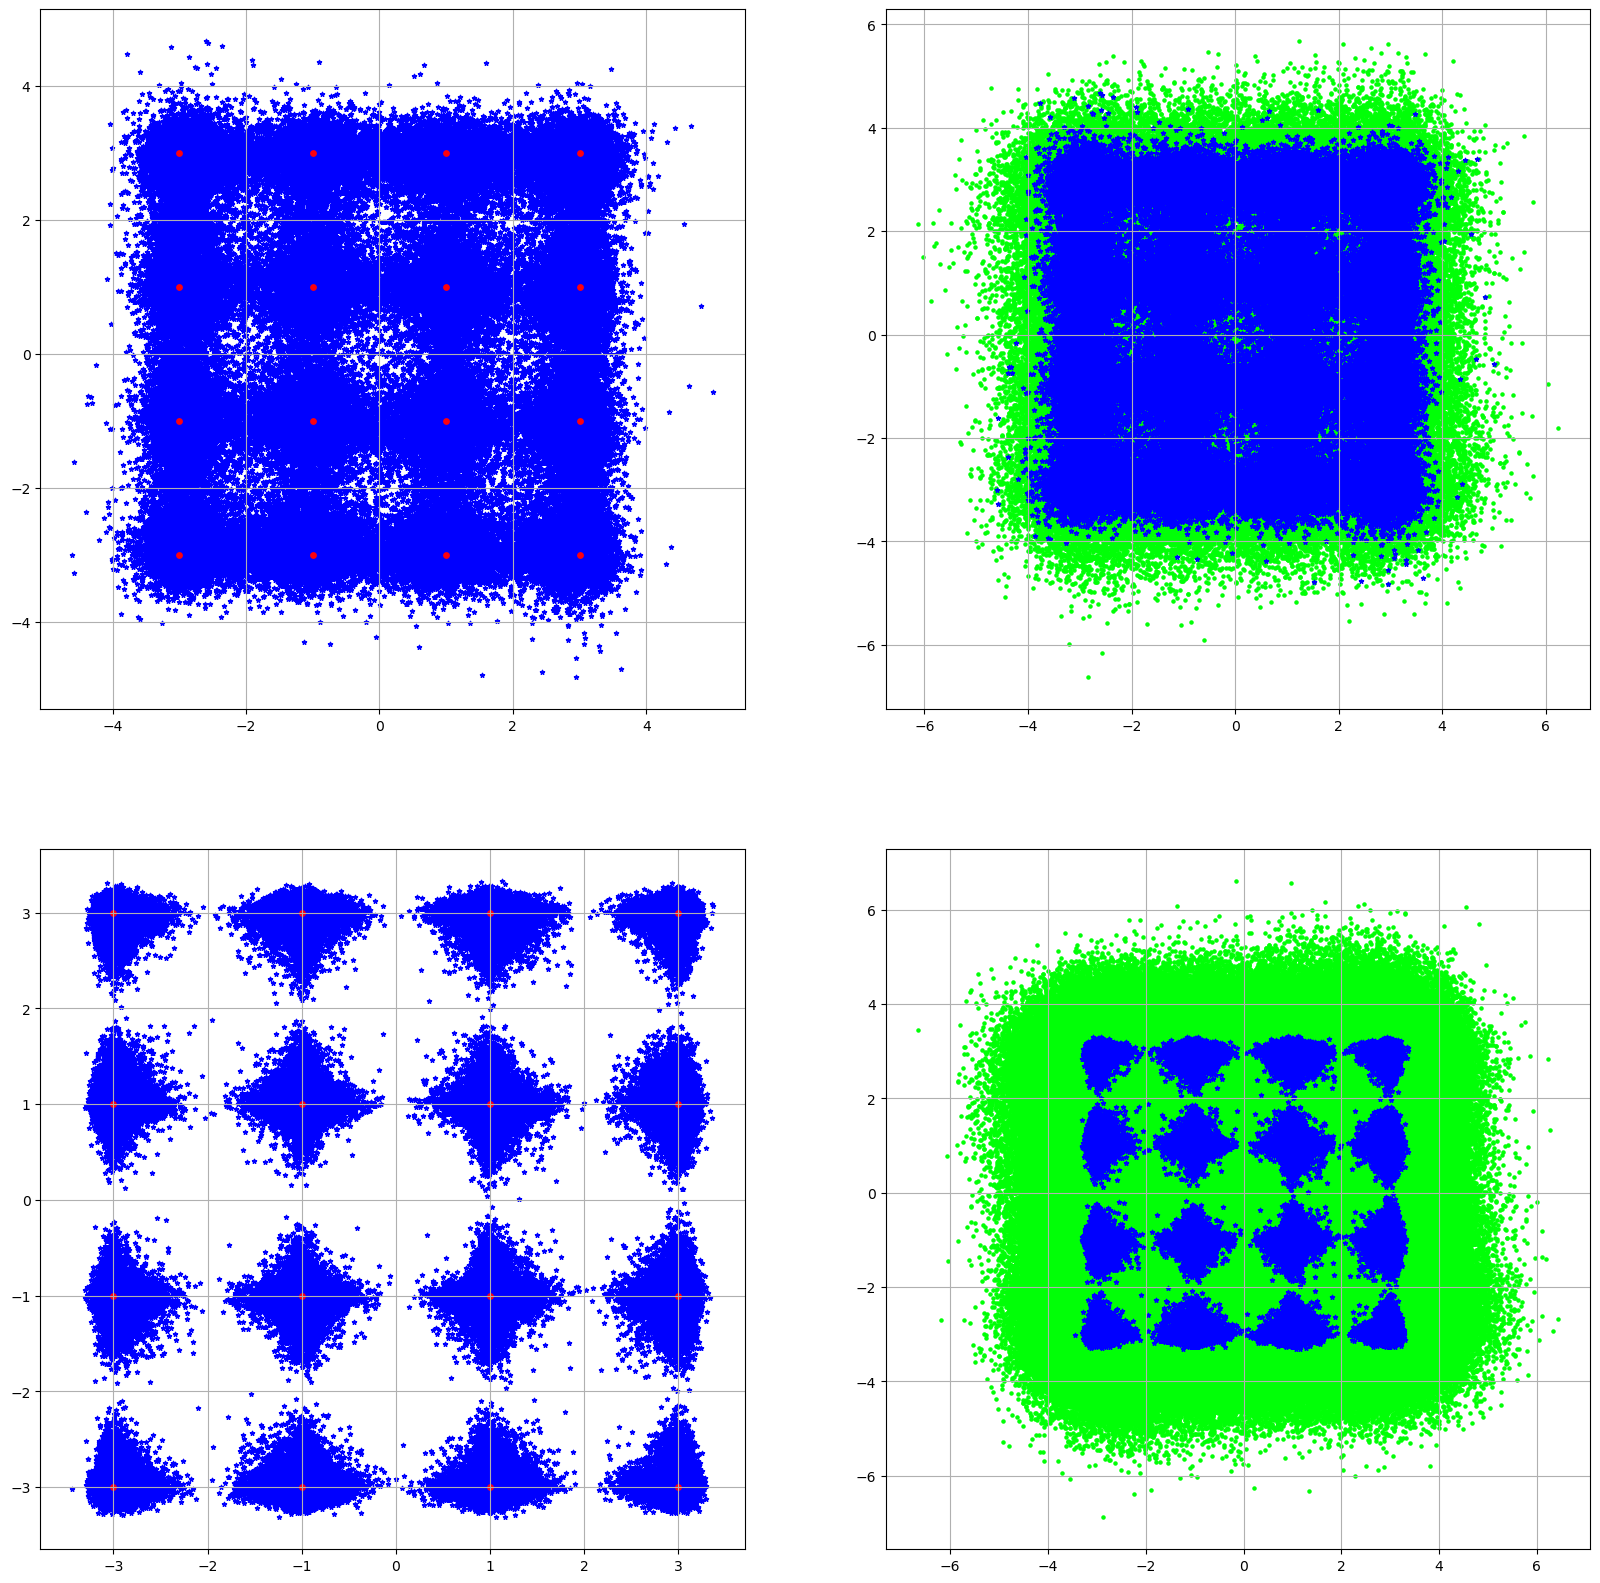

In [248]:
plot_result(p_ave_dbm, points_predict_for_test, points_orig_for_test, points_predict_train, points_orig_train)

#### Cross test same model for different power levels

In [245]:
_ = predict_and_eval((xgb_reg, ), 
                     X_test_2dbm, points_init_test_2dbm, 
                     p_ave_dbm=2, scale_type='constellation', name='RF 2 dbm test')

_ = predict_and_eval((xgb_reg, ), 
                     X_test_3dbm, points_init_test_3dbm, 
                     p_ave_dbm=3, scale_type='constellation', name='RF 3 dbm test')

_ = predict_and_eval((xgb_reg, ), 
                     X_test_4dbm, points_init_test_4dbm, 
                     p_ave_dbm=4, scale_type='constellation', name='RF 4 dbm test')

_ = predict_and_eval((xgb_reg, ), 
                     X_test_5dbm, points_init_test_5dbm, 
                     p_ave_dbm=5, scale_type='constellation', name='RF 5 dbm test')

_ = predict_and_eval((xgb_reg, ), 
                     X_test_6dbm, points_init_test_6dbm, 
                     p_ave_dbm=6, scale_type='constellation', name='RF 6 dbm test')

_ = predict_and_eval((xgb_reg, ), 
                     X_test_7dbm, points_init_test_7dbm, 
                     p_ave_dbm=7, scale_type='constellation', name='RF 7 dbm test')

_ = predict_and_eval((xgb_reg, ), 
                     X_test_8dbm, points_init_test_8dbm, 
                     p_ave_dbm=8, scale_type='constellation', name='RF 8 dbm test')

P_ave [dBm] =  2
Scale data to correspond to initial constellation
-----RF 2 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.0021800994873046875, 1143) / (0.002017974853515625, 1058) / 0.0001621246337890625)
ber from EVM_rms (orig / pred / delta) (0.0018617838857082657 / 2.9922921682768465e-06 / 0.001858791593539989)
q-factor [dB] (orig / pred / delta) (9.099499423952546 / 9.173778609349437 / 0.07427918539689138)
EVM [%] (orig / pred / delta) (15.91897452062742 / 10.014334255238209 / 5.904640265389212
P_ave [dBm] =  3
Scale data to correspond to initial constellation
-----RF 3 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.0046710968017578125, 2449) / (0.003570556640625, 1872) / 0.0011005401611328125)
ber from EVM_rms (orig / pred / delta) (0.0039258025772962585 / 1.8943771084673134e-05 / 0.003906858806211585)
q-factor [dB] (orig / pred / delta) (8.29703186548497 / 8.595662329079936 / 0.29863046359496614)
EVM [%] (orig / pred / delta) (17.

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

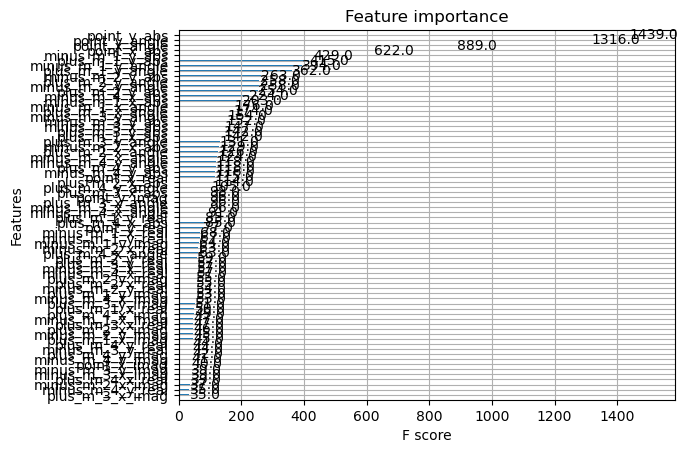

In [96]:
xgb.plot_importance(xgb_reg)

#### XGBoost interface

In [ ]:
# form dtrain matrix for xgboost
dtrain = xgb.DMatrix(X_train, label=y_train)

param = {'max_depth': 100, 
         'objective': 'reg:squarederror',
         'tree_method': 'gpu_hist',  # GPU cersion of hist algorithm
         'lambda': 1.0,  # 1.0 - L2 regularization term on weights. Increasing this value will make model more conservative
         'alpha': 0.0,  # 0.0 - L1 regularization term on weights. Increasing this value will make model more conservative.
        }

## K-means

In [ ]:
from sklearn.cluster import KMeans


In [ ]:
# path_to_data = 'C:/Users/190243539/PycharmProjects/nn_essential/error_statistics/data/data_collected_3.pkl'
path_to_data = 'C:/Users/190243539/PycharmProjects/nn_essential/benchmark/data/data_collected_extended_wo_noise_1.pkl'
path_to_data_w_noise = 'C:/Users/190243539/PycharmProjects/nn_essential/benchmark/data/data_collected_extended_w_noise_1.pkl'

df = pd.read_pickle(path_to_data)
print(df.columns.values)
print(df['p_ave_dbm'])
# df_noise = pd.read_pickle(path_to_data_w_noise)

# train_runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# train_runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
train_runs = [0, 1, 2]
test_runs = [3, 4]

p_ave_dbm = 1
z_km = 80 * 20
n_channels = 1

df_tree = get_data_wo_neighbor(df, z_km, p_ave_dbm, n_channels, train_runs)
df_tree_for_test = get_data_wo_neighbor(df, z_km, p_ave_dbm, n_channels, test_runs)
# df_tree_for_test = get_data_wo_neighbor(df_noise, z_km, p_ave_dbm, n_channels, test_runs)


print(df_tree.head())
df = pd.DataFrame([])
df_noise = pd.DataFrame([])
del df, df_noise

In [ ]:
df_tree

In [ ]:
# X = df_tree[['point_orig_real', 'point_orig_imag']].values
X = df_tree[['point_received_real', 'point_received_imag']].values
np.shape(X)


In [ ]:
# Instantiate the k-means model with the desired number of clusters
kmeans = KMeans(n_clusters=16)

# Fit the model to the data
kmeans.fit(X)

# Get the cluster assignments for each point
labels = kmeans.labels_

# Get the coordinates of the cluster centers
cluster_centers = kmeans.cluster_centers_

In [ ]:
X_test = df_tree_for_test[['point_received_real', 'point_received_imag']].values

In [ ]:
predictions = kmeans.predict(X_test)

In [ ]:
p_pred_temp = kmeans.cluster_centers_[predictions]

In [ ]:
predictions

In [ ]:
# p_init = df_tree[['point_orig_real', 'point_orig_imag']].values
p_init = df_tree_for_test[['point_orig_real', 'point_orig_imag']].values
p_init = p_init[:, 0] + 1j * p_init[:, 1]
# p_prop = X[:, 0] + 1j * X[:, 1]
p_prop = X_test[:, 0] + 1j * X_test[:, 1]
p_predict = p_pred_temp[:, 0] + 1j * p_pred_temp[:, 1]

In [ ]:
p_ave_expl = (10 ** (p_ave_dbm / 10)) / 1000
mod_type = hpcom.modulation.get_modulation_type_from_order(16)
scale_constellation = hpcom.modulation.get_scale_coef_constellation(mod_type) / np.sqrt(p_ave_expl / 2)
constellation = hpcom.modulation.get_constellation('16qam')

p_found = hpcom.modulation.get_nearest_constellation_points_new(p_prop, constellation)
p_found_pred = hpcom.modulation.get_nearest_constellation_points_new(p_predict, constellation)

ber_orig = hpcom.metrics.get_ber_by_points(p_init, p_found, '16qam')
ber_predict = hpcom.metrics.get_ber_by_points(p_init, p_found_pred, '16qam')

print(ber_orig, ber_predict)

In [ ]:

#Visualizing the cluster
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='black')

## Test some features

In [ ]:
import xgboost as xgb
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

# Generate a random dataset
X, y = make_regression(n_samples=1000, n_features=4, noise=0.1)

# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Convert the data into the format required by XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.1,
    'lambda': 1.0
}

# Train the XGBoost model
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

# Use the trained model to make predictions on the test data
y_pred = bst.predict(dtest)

# Evaluate the performance of the model
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

import numpy as np

def custom_objective(preds, dtrain):
    labels = dtrain.get_label()
    mse_loss = np.mean((preds - labels)**2)
    mae_loss = np.mean(np.abs(preds - labels))
    return 'custom_loss', mse_loss + mae_loss, False


params['objective'] = custom_objective
bst = xgb.train(params, dtrain, num_rounds)

y_pred = bst.predict(dtest)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
